In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from web3 import Web3, IPCProvider
%matplotlib inline
from scipy import stats
import powerlaw
import networkx as nx

In [2]:
genesis = pd.read_csv('genesisLevel.csv')
genesis1 = pd.read_csv('genesisLevel_1.csv')
genesisLvl = genesis.append(genesis1, ignore_index=True)
# genesisBal = pd.read_csv('')
transactions = pd.read_csv('transaction_till_100000.csv', low_memory=False)

In [30]:
#Basic Statistics
ft = open('stats_Levels.csv','a')
ft.write('Median: %f' %np.median(genesisLvl.level))
ft.write('\n')
ft.write(str(stats.mode(list(genesisLvl.level))))
desc=stats.describe(list(genesisLvl.level))
ft.write('\n')
ft.write(str(desc))
ft.write('\n')
ft.write('Standard Variance: %f' %np.var(genesisLvl.level))
var=np.var(list(genesisLvl.level))
std=np.sqrt(var)
ft.write('\n')
ft.write('Standard Deviation: %f' %std)
ft.close()

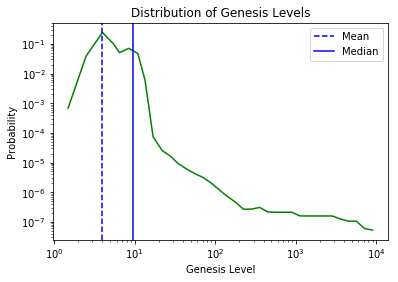

In [5]:
#Distribution of the addresses onto the levels
levels = list(genesisLvl.level)
mean = np.mean(levels)
median = np.median(levels)

fig0 = powerlaw.plot_pdf(levels, color='g', label = 'Probability Density Function')

fig0.axvline(label='Mean',x=mean,linestyle='solid', color ='blue')
fig0.axvline(label='Median',x=median,linestyle='dashed',color ='blue')

fig0.set_xlabel('Genesis Level')
fig0.set_ylabel('Probability')
fig0.set(title='Distribution of Genesis Levels')

median_line=mlines.Line2D([], [], color='blue', label='Median')
mean_line=mlines.Line2D([], [], color='blue', linestyle = 'dashed', label='Mean')


fig0.legend(handles=[mean_line,median_line], loc='upper right')
plt.savefig('levelDistr.png') #use .pgf to include the figure into latex document

In [ ]:
#Average per-wallet balance sorted by level (skeletal, not tested yet)
walletCount =[levels.count(i) for i in range (1,max(levels))]
levelSum = [0 for i in range (1,max(levels))]

#table containing the address with its balance and genesis Level
genesisLvlBal = genesisLvl.set_index('address').join(genesisBal.set_index('adress')) 
#get the cumulative balance per level
for line in genesisLvlBal.iteritems():
    levelSum[line[1]] = levelSum[line[1]] + levelSum[line[2]]  #todo check the correctness of the indices
#normalize the summed balance by the number of wallets 
for i in range (0,len(levelSum)):
    levelSum[i] = levelSum[i] / walletCount[i] 

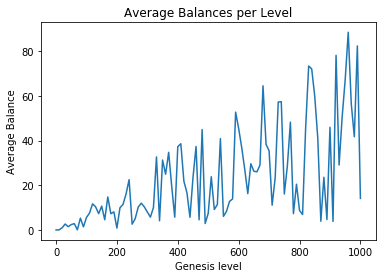

In [6]:
#plot the average balance

levelSum = [i* np.random.rand() for i in range (0,101)] #dummy values
x = np.linspace(0,1000,101) # parameters are (start,end,number of intervals)
plt.plot(x,levelSum)

plt.xlabel('Genesis level')
plt.ylabel('Average Balance')

plt.title('Average Balances per Level')

plt.show()

In [7]:
#What are the distances between the levels within a specific transaction
df = transactions.drop(['Value','Time','Block'],axis=1) 

lvlDict ={}
for line in genesisLvl.itertuples():
    addr = line[1]
    lvlDict[addr] = line[2]
lvlDict['ethereum'] = 0
dist = []
dist_nonEthr = []
fails = []

for line in df.itertuples():
    fromAdr = line[1]
    toAdr = line[2]
    try:
        diff = np.abs(lvlDict[fromAdr] - lvlDict[toAdr])
        dist.insert(line[0],diff)
        if fromAdr != 'ethereum':
            dist_nonEthr.insert(line[0],diff)
    except:
        fails.append(fromAdr)

print(len(fails))
print(len(dist))
print(len(dist_nonEthr))

68
143836
26560


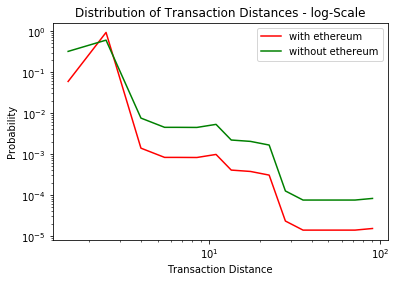

In [29]:
mean = np.mean(dist)
median = np.median(dist_nonEthr)
distances = [i+1 for i in dist ]
distances2 = [i+1 for i in dist_nonEthr ] # otherwise pdf will output error for zero

fig, ax = plt.subplots()

ax = powerlaw.plot_pdf(distances, color='r', label = 'with ethereum')
line2 = powerlaw.plot_pdf(distances2, color='g', label = 'without ethereum')

#fig0 = powerlaw.plot_pdf(distances, color='g', label = 'Probability Density Function')

# ax.axvline(label='Mean1: '+str(mean),x=mean,linestyle='dashed', color ='r')
# ax.axvline(label='Mean2: '+str(mean2),x=mean,linestyle='dashed', color ='g')

ax.set_xlabel('Transaction Distance')
ax.set_ylabel('Probability')
ax.set(title='Distribution of Transaction Distances - log-Scale')
# fig0.set(title='Distribution of Transaction Distances - linear x-Scale')


#fig0.set_xscale('linear')
# fig1.set_yscale('linear')

ax.legend()
#plt.show()
plt.savefig('distDistr.pgf') #use .pgf to include the figure into latex document

In [45]:
ft = open('stats_transactionDistances.csv','a')
desc = stats.describe(dist)
ft.write(str(desc))
ft.write('\n')
ft.close()
    